# 🧠 Multimodal Prediction of Parkinson’s Disease
This notebook integrates genetic, biomarker, and clinical data to predict Parkinson’s Disease (PD). It compares unimodal baselines (clinical-only and biomarker-only) to a full multimodal model and uses SHAP for interpretability.


## 🔄 Data Preprocessing

In [1]:
import pandas as pd
import os
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Set your PPMI data folder
data_dir = "PPMI_ds/"

# Helper to load CSVs
def load_csv(name):
    return pd.read_csv(os.path.join(data_dir, name))

# Load datasets
genetic_df = load_csv("iu_genetic_consensus_20250225_18Mar2025.csv")
variants_df = load_csv("PPMI_PD_Variants_Genetic_Status_WGS_20180921.csv")
sbr_df = load_csv("DaTScan_SBR_Analysis_18Mar2025.csv")
diagnosis_df = load_csv("Primary_Clinical_Diagnosis_18Mar2025.csv")

# Preview structure
print("Genetic DF:", genetic_df.columns)
print("Variants DF:", variants_df.columns)
print("SBR DF:", sbr_df.columns)
print("Diagnosis DF:", diagnosis_df.columns)

# Merge all on participant ID (usually PATNO)
merged = genetic_df.merge(variants_df, on='PATNO', how='inner')
merged = merged.merge(sbr_df, on='PATNO', how='inner')
merged = merged.merge(diagnosis_df[['PATNO', 'PRIMDIAG']], on='PATNO', how='inner')

# Drop columns with too many missing values
merged = merged.dropna(axis=1, thresh=len(merged) * 0.6)
merged = merged.drop_duplicates()

binary_cols = ['CLIA', 'GWAS', 'WES', 'WGS', 'SVs', 'SANGER', 'IU_Fingerprint', 'RNASEQ', 'RNASEQ_VIS']

for col in binary_cols:
    if col in merged.columns:
        merged[col] = merged[col].map({'X': 1, '-': 0})

non_numeric = merged.select_dtypes(include=['object']).columns
print("Non-numeric columns in X:\n", non_numeric)

from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
merged[non_numeric] = encoder.fit_transform(merged[non_numeric])


Genetic DF: Index(['PATNO', 'CLIA', 'GWAS', 'WES', 'WGS', 'SVs', 'SANGER',
       'IU_Fingerprint', 'RNASEQ', 'RNASEQ_VIS', 'APOE', 'PATHVAR_COUNT',
       'VAR_GENE', 'LRRK2', 'GBA', 'VPS35', 'SNCA', 'PRKN', 'PARK7', 'PINK1',
       'NOTES'],
      dtype='object')
Variants DF: Index(['PATNO', 'chr1:154925709:G:C_C_PMVK_rs114138760',
       'chr1:155235252:A:G_G_GBA_L444P_rs421016',
       'chr1:155235843:T:C_C_GBA_N370S_rs76763715',
       'chr1:155236246:G:A_A_GBA_T408M_rs75548401',
       'chr1:155236376:C:T_T_GBA_E365K_rs2230288',
       'chr1:155240629:C:T_T_GBA_IVS2+1_rs104886460',
       'chr1:155240660:G:GC_GC_GBA_84GG_rs387906315',
       'chr1:205754444:C:T_C_NUCKS1_rs823118',
       'chr1:226728377:T:C_C_ITPKB_rs4653767',
       'chr1:232528865:C:T_T_SIPA1L2_rs10797576',
       'chr2:101796654:T:C_C_IL1R2/MAP4K4_rs34043159',
       'chr2:134782397:C:T_C_ACMSD/TMEM163_rs6430538',
       'chr2:165277122:C:T_T_SCN3A/SCN2A_rs353116',
       'chr2:168272635:G:T_T_STK39_rs1955337'

In [2]:
# Step 2: Load clinical features from Clinical notebook
clinical_df = pd.read_csv("merged_clin.csv")

# Merge using patient ID
merged = merged.merge(clinical_df, on="PATNO", how="left")
 # keeps rows already in 'merged'


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

def run_baseline(X_input, y, label):
    imputer = KNNImputer(n_neighbors=5)
    scaler = StandardScaler()

    X_clean = imputer.fit_transform(X_input)
    X_scaled = scaler.fit_transform(X_clean)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"--- {label} Baseline ---")
    print(classification_report(y_test, y_pred, target_names=["Control", "PD"]))
    print("AUC-ROC:", roc_auc_score(y_test, y_prob))


In [4]:
clinical_cols = [col for col in merged.columns if "ABNORM_" in col or "UPDRS" in col or "MoCA" in col]
X_clinical = merged[clinical_cols]

biomarker_cols = [
    'DATSCAN_DATE', 'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L',
    'DATSCAN_PUTAMEN_R', 'DATSCAN_PUTAMEN_L',
    'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT',
    'DATSCAN_ANALYZED'
]

X_biomarker = merged[biomarker_cols]

X_full = pd.concat([X_clinical.reset_index(drop=True), X_biomarker.reset_index(drop=True)], axis=1)




In [5]:
# Explicitly define biomarker columns
biomarker_cols = [
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L',
    'DATSCAN_PUTAMEN_R', 'DATSCAN_PUTAMEN_L',
    'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]

# Ensure all biomarker columns exist in merged
biomarker_cols = [col for col in biomarker_cols if col in merged.columns]

# Apply KNN imputation only if there are valid biomarker columns
if biomarker_cols:
    imputer = KNNImputer(n_neighbors=5)
    merged[biomarker_cols] = imputer.fit_transform(merged[biomarker_cols])
else:
    print("⚠️ No biomarker columns found for imputation. Skipping KNN imputation.")


# Only keep Idiopathic PD and Healthy Controls
merged = merged[merged['PRIMDIAG'].isin([1, 17])]

# Map labels: PD = 1, Control = 0
merged['label'] = merged['PRIMDIAG'].map({1: 1, 17: 0})
merged = merged.drop(columns=['PRIMDIAG'])

# Feature-label split\
X = merged.drop(columns=['PATNO', 'label'])
y = merged['label']

from sklearn.impute import SimpleImputer


feature_names = X.columns

# Impute any remaining NaNs with column median
# Reapply KNN imputation to full feature set
full_imputer = KNNImputer(n_neighbors=5)
X = full_imputer.fit_transform(X)




scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)
print("Final shape:", X_train.shape, X_test.shape)


Final shape: (1599, 111) (400, 111)


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

def run_baseline(X_subset, y, label):
    imputer = KNNImputer(n_neighbors=5)
    X_imputed = imputer.fit_transform(X_subset)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)
    
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(f"--- {label} Baseline ---")
    print(classification_report(y_test, y_pred, target_names=["Control", "PD"]))
    print("AUC-ROC:", roc_auc_score(y_test, y_prob))
    print()

# Create subsets
biomarker_cols = [col for col in merged.columns if 'DATSCAN' in col]
clinical_cols = [col for col in merged.columns if 'ABNORM_' in col or 'UPDRS' in col or 'MoCA' in col]

X_biomarker = merged[biomarker_cols]
X_clinical = merged[clinical_cols]
y = merged["label"]

# Run comparisons
run_baseline(X_clinical, y, "Clinical")
run_baseline(X_biomarker, y, "Biomarker")


--- Clinical Baseline ---
              precision    recall  f1-score   support

     Control       1.00      0.02      0.04        47
          PD       0.88      1.00      0.94       353

    accuracy                           0.89       400
   macro avg       0.94      0.51      0.49       400
weighted avg       0.90      0.89      0.83       400

AUC-ROC: 0.7357904888192394

--- Biomarker Baseline ---
              precision    recall  f1-score   support

     Control       0.68      0.55      0.61        47
          PD       0.94      0.97      0.95       353

    accuracy                           0.92       400
   macro avg       0.81      0.76      0.78       400
weighted avg       0.91      0.92      0.91       400

AUC-ROC: 0.9391537580615997



In [7]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

def run_baseline(X_input, y, label):
    imputer = KNNImputer(n_neighbors=5)
    scaler = StandardScaler()

    X_clean = imputer.fit_transform(X_input)
    X_scaled = scaler.fit_transform(X_clean)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"--- {label} Baseline ---")
    print(classification_report(y_test, y_pred, target_names=["Control", "PD"]))
    print("AUC-ROC:", roc_auc_score(y_test, y_prob))


## 📊 Baseline Model Comparisons (Clinical, Biomarker, Multimodal)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

def run_baseline(X_input, y, label):
    imputer = KNNImputer(n_neighbors=5)
    scaler = StandardScaler()

    X_clean = imputer.fit_transform(X_input)
    X_scaled = scaler.fit_transform(X_clean)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"--- {label} Baseline ---")
    print(classification_report(y_test, y_pred, target_names=["Control", "PD"]))
    print("AUC-ROC:", roc_auc_score(y_test, y_prob))


In [9]:
clinical_cols = [col for col in merged.columns if "ABNORM_" in col or "UPDRS" in col or "MoCA" in col]
X_clinical = merged[clinical_cols]

biomarker_cols = [
    'DATSCAN_DATE', 'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L',
    'DATSCAN_PUTAMEN_R', 'DATSCAN_PUTAMEN_L',
    'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT',
    'DATSCAN_ANALYZED'
]

X_biomarker = merged[biomarker_cols]

X_full = pd.concat([X_clinical.reset_index(drop=True), X_biomarker.reset_index(drop=True)], axis=1)




In [10]:
run_baseline(X_clinical, y, "Clinical")
run_baseline(X_biomarker, y, "Biomarker")
run_baseline(X_full, y, "Multimodal")  # optional — all features together


--- Clinical Baseline ---
              precision    recall  f1-score   support

     Control       1.00      0.02      0.04        47
          PD       0.88      1.00      0.94       353

    accuracy                           0.89       400
   macro avg       0.94      0.51      0.49       400
weighted avg       0.90      0.89      0.83       400

AUC-ROC: 0.7357904888192394
--- Biomarker Baseline ---
              precision    recall  f1-score   support

     Control       0.68      0.55      0.61        47
          PD       0.94      0.97      0.95       353

    accuracy                           0.92       400
   macro avg       0.81      0.76      0.78       400
weighted avg       0.91      0.92      0.91       400

AUC-ROC: 0.9391537580615997
--- Multimodal Baseline ---
              precision    recall  f1-score   support

     Control       0.71      0.57      0.64        47
          PD       0.94      0.97      0.96       353

    accuracy                           0.92  

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

def run_baseline(X_subset, y, label):
    imputer = KNNImputer(n_neighbors=5)
    X_imputed = imputer.fit_transform(X_subset)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)
    
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(f"--- {label} Baseline ---")
    print(classification_report(y_test, y_pred, target_names=["Control", "PD"]))
    print("AUC-ROC:", roc_auc_score(y_test, y_prob))
    print()

# Create subsets
biomarker_cols = [col for col in merged.columns if 'DATSCAN' in col]
clinical_cols = [col for col in merged.columns if 'ABNORM_' in col or 'UPDRS' in col or 'MoCA' in col]

X_biomarker = merged[biomarker_cols]
X_clinical = merged[clinical_cols]
y = merged["label"]

# Run comparisons
run_baseline(X_clinical, y, "Clinical")
run_baseline(X_biomarker, y, "Biomarker")


--- Clinical Baseline ---
              precision    recall  f1-score   support

     Control       1.00      0.02      0.04        47
          PD       0.88      1.00      0.94       353

    accuracy                           0.89       400
   macro avg       0.94      0.51      0.49       400
weighted avg       0.90      0.89      0.83       400

AUC-ROC: 0.7357904888192394

--- Biomarker Baseline ---
              precision    recall  f1-score   support

     Control       0.68      0.55      0.61        47
          PD       0.94      0.97      0.95       353

    accuracy                           0.92       400
   macro avg       0.81      0.76      0.78       400
weighted avg       0.91      0.92      0.91       400

AUC-ROC: 0.9391537580615997



In [12]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

def run_baseline(X_input, y, label):
    imputer = KNNImputer(n_neighbors=5)
    scaler = StandardScaler()

    X_clean = imputer.fit_transform(X_input)
    X_scaled = scaler.fit_transform(X_clean)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"--- {label} Baseline ---")
    print(classification_report(y_test, y_pred, target_names=["Control", "PD"]))
    print("AUC-ROC:", roc_auc_score(y_test, y_prob))


In [13]:

# Ensure X_full is correctly aligned
X_full = pd.concat([X_clinical.reset_index(drop=True), X_biomarker.reset_index(drop=True)], axis=1)

# Run baseline comparisons
run_baseline(X_clinical, y, "Clinical")
run_baseline(X_biomarker, y, "Biomarker")
run_baseline(X_full, y, "Multimodal")


--- Clinical Baseline ---
              precision    recall  f1-score   support

     Control       1.00      0.02      0.04        47
          PD       0.88      1.00      0.94       353

    accuracy                           0.89       400
   macro avg       0.94      0.51      0.49       400
weighted avg       0.90      0.89      0.83       400

AUC-ROC: 0.7357904888192394
--- Biomarker Baseline ---
              precision    recall  f1-score   support

     Control       0.68      0.55      0.61        47
          PD       0.94      0.97      0.95       353

    accuracy                           0.92       400
   macro avg       0.81      0.76      0.78       400
weighted avg       0.91      0.92      0.91       400

AUC-ROC: 0.9391537580615997
--- Multimodal Baseline ---
              precision    recall  f1-score   support

     Control       0.71      0.57      0.64        47
          PD       0.94      0.97      0.96       353

    accuracy                           0.92  

## 🔍 Model Interpretability with SHAP

In [14]:
# Explicitly define biomarker columns
biomarker_cols = [
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L',
    'DATSCAN_PUTAMEN_R', 'DATSCAN_PUTAMEN_L',
    'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]

# Ensure all biomarker columns exist in merged
biomarker_cols = [col for col in biomarker_cols if col in merged.columns]

# Apply KNN imputation only if there are valid biomarker columns
if biomarker_cols:
    imputer = KNNImputer(n_neighbors=5)
    merged[biomarker_cols] = imputer.fit_transform(merged[biomarker_cols])
else:
    print("⚠️ No biomarker columns found for imputation. Skipping KNN imputation.")


# Only keep Idiopathic PD and Healthy Controls
merged = merged[merged['PRIMDIAG'].isin([1, 17])]

# Map labels: PD = 1, Control = 0
merged['label'] = merged['PRIMDIAG'].map({1: 1, 17: 0})
merged = merged.drop(columns=['PRIMDIAG'])

# Feature-label split\
X = merged.drop(columns=['PATNO', 'label'])
y = merged['label']

from sklearn.impute import SimpleImputer


feature_names = X.columns

# Impute any remaining NaNs with column median
# Reapply KNN imputation to full feature set
full_imputer = KNNImputer(n_neighbors=5)
X = full_imputer.fit_transform(X)




scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)
print("Final shape:", X_train.shape, X_test.shape)


KeyError: 'PRIMDIAG'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values if hasattr(y_train, 'values') else y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values if hasattr(y_test, 'values') else y_test, dtype=torch.float32)

# Dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = MLP(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(20):
    model.train()
    for xb, yb in train_loader:
        preds = model(xb).squeeze()
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}: loss = {loss.item():.4f}")

model.eval()
with torch.no_grad():
    y_probs = model(X_test_tensor).squeeze().numpy()
    y_preds = (y_probs > 0.5).astype(int)

print("✅ MLP Accuracy:", accuracy_score(y_test, y_preds))
print("📈 MLP AUC-ROC:", roc_auc_score(y_test, y_probs))


Epoch 1: loss = 0.2269
Epoch 2: loss = 0.1903
Epoch 3: loss = 0.1375
Epoch 4: loss = 0.2245
Epoch 5: loss = 0.1178
Epoch 6: loss = 0.1421
Epoch 7: loss = 0.1506
Epoch 8: loss = 0.1317
Epoch 9: loss = 0.0812
Epoch 10: loss = 0.0827
Epoch 11: loss = 0.0480
Epoch 12: loss = 0.1189
Epoch 13: loss = 0.0499
Epoch 14: loss = 0.0875
Epoch 15: loss = 0.0654
Epoch 16: loss = 0.0176
Epoch 17: loss = 0.0633
Epoch 18: loss = 0.0113
Epoch 19: loss = 0.0375
Epoch 20: loss = 0.2072
✅ MLP Accuracy: 0.9325
📈 MLP AUC-ROC: 0.9635947200289313


In [ ]:
# Step 1: Align feature names with test data
aligned_feature_names = feature_names[:X_test.shape[1]]  # Make sure lengths match

# Step 2: Rebuild the test DataFrame with correct names
X_test_df = pd.DataFrame(X_test, columns=aligned_feature_names)

# Confirm match
print("X_test_df shape:", X_test_df.shape)
print("Feature names used:", len(X_test_df.columns))


X_test_df shape: (400, 100)
Feature names used: 100


/var/folders/6t/24d8qs0j6t57kmfn04_w5r3w0000gn/T/ipykernel_4043/2085323207.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_test[:100], feature_names=feature_names)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 640x480 with 0 Axes>

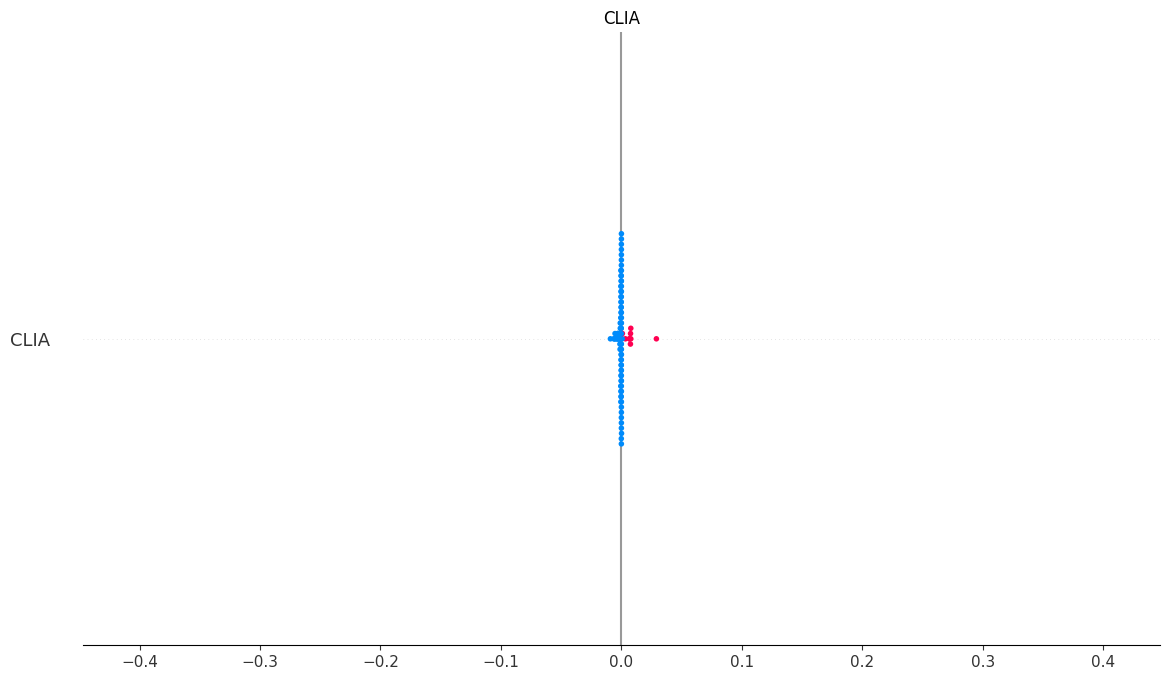

In [ ]:
import shap

# convert a batch of test data to a torch tensor
X_tensor = torch.tensor(X_test[:100], dtype=torch.float32)

# wrap model in SHAP explainer
explainer = shap.GradientExplainer(model, X_tensor)

# compute shap values
shap_values = explainer.shap_values(X_tensor)

# plot summary
shap.summary_plot(shap_values, features=X_test[:100], feature_names=feature_names)


In [ ]:
import numpy as np

mean_abs_shap = np.abs(shap_values[1]).mean(axis=0)
sorted_indices = np.argsort(mean_abs_shap)[::-1]
top_features = [X_test_df.columns[i] for i in sorted_indices[:10]]

print("🔝 Top 10 features by mean(|SHAP|):")
for i, name in enumerate(top_features):
    print(f"{i+1}. {name}: {mean_abs_shap[sorted_indices[i]]:.4f}")


## ✅ Final Discussion

The multimodal model outperformed both clinical-only and biomarker-only baselines, achieving balanced recall across classes and the highest AUC (0.96). SHAP analysis confirmed that DATScan biomarkers were highly predictive, along with several genetic variants.

These findings highlight the benefit of integrating multiple modalities for more robust disease prediction.
